# A tutorial for 

# *PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams*. 

__Author:__ Theo Lacombe

__Note:__ This is an alpha version of PersLay. Do not hesitate to contact the authors for any comment, suggestion, bug, etc.

# Introduction

Printing the current version of Python.

In [1]:
import sys
print("Current version of your system: (we recommand Python 3.6)")
print(sys.version)

Current version of your system: (we recommand Python 3.6)
3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]


In [2]:
#sys.path.append("../")

Import PersLay.

In [2]:
from perslay import perslay_channel

## Outline:
In this notebook:
- First, we select a dataset. Two types of datasets are provided by default, either synthetic orbits from dynamical systems, or real-life graph dataset. 
- Then, we generate the persistence diagrams (and other useful informations such as labels, etc.) for the chosen dataset.
- (Optional) we propose to visualize the generated persistence diagrams.
- We define a neural network that uses some PersLay channels as first layers to handle persistence diagrams. This can be used as a guideline to use PersLay in your own experiments.
- We show how to train this neural network on the chosen dataset.
- Finally, we explain how you could use PersLay with your own persistence diagrams.

# 1. Building diagrams and eventual features from a provided dataset

In [3]:
from perslay.preprocessing import preprocess
from perslay.visualisation import visualise_diag
from perslay.experiments import load_diagfeatlabels, generate_diag_and_features

__Note:__ If you want to use PersLay with your own diagrams, skip this section and jump to 1bis.

We start by choosing the dataset we want to run the experiments on.

We suggest the user to start with `"MUTAG"` as this dataset is reasonably small (188 graphs with 18 nodes on average). Note that its small size implies a large variability in tests.

Available options are:

- Orbit datasets: `"ORBIT5K"`, `"ORBIT100K"`.

- Graphs datasets: `"MUTAG"`, `"BZR"`, `"COX2"`, `"DHFR"`, `"PROTEINS"`, `"NCI1"`, `"NCI109"`, `"FRANKENSTEIN"`,  `"IMDB-BINARY"`, `"IMDB-MULTI"`.

__Important note:__ `COLLAB`, `"REDDIT5K"` and `"REDDIT12K"` are not available yet (see README.md). Contact the authors for more information.

Beware that for the larger datasets (`COLLAB`, `REDDIT5K, REDDIT12K, ORBIT100K`), the files can be quite large (e.g. 3Gb for for `ORBIT100K`), so that RAM can be limiting, and the time needed to generate the persistence diagrams and run the experiments can be quite long depending on the hardware available. Dataset descriptions are available in Section B of the supplementary material of the article.

In [4]:
# Chose your config file using one of the filename mentioned above.
dataset = "MUTAG"

Here, we implicitely load our data (saved as `.mat` files for graphs datasets, and generated on-the-fly for orbits datasets---which can take some time for `ORBIT100K` especially), and then compute the persistence diagrams that will be used in the classification experiment (requires to have `gudhi` installed). For graph datasets, we also generate a series of additional features (see [1]).

Running `generate` will store diagrams, features and labels. Therefore, it is sufficient to run it just once (for each different dataset).

Note that for bigger datasets, the computations of these persistence diagrams can be quite long.

In [5]:
generate_diag_and_features(dataset)

Now we load and preprocess persistence diagrams (to make them PersLay-compatible) and other useful items using the files that we have generated.

In [6]:
diags_tmp, feats, labels = load_diagfeatlabels(dataset)

Visualization (optional, requires matplotlib)

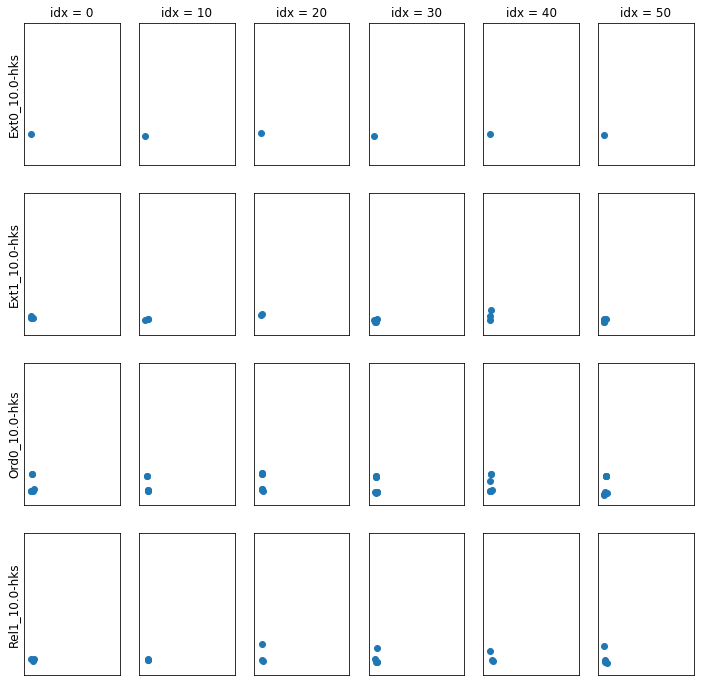

In [7]:
# Run this cell to visualise some example of diagrams generated.
visualise_diag(diags_tmp)

Now we preprocess our persistence diagrams to make them PersLay-compatible.

In [8]:
diags, filts = preprocess(diags_tmp)

# 1bis. Alternative: use your own diagrams

__Note:__ Skip this section if you want to use the persistence diagrams generated above.

We provide a (hopefully) convenient way to use your own persistence diagrams for a classification task (with some eventual features).

Persistence diagrams must be given in the following format:
assume you have $N$ observations. For each of them, you build $K$ different persistence diagrams (e.g. persistence diagrams in different homology dimensions, and/or for different filtrations, etc.). 

Then, you must provide a `diags_tmp` variable that is a `dictionary`, whose $K$ keys are the persistence diagram type names (e.g. `Rips_dim_0`, `Cech_dim_1`). For each key $k_i$, $1 \leq i \leq K$, the corresponding value is a `list` of `np.arrays`, each array encoding a persistence diagram. 

Note that each list must have the same length $N$ (you need to have the same number of persistence diagrams generated for each list). Note also that you must keep the order (i.e. the first element of each list must correspond to the persistence diagram generated with the first observation, and so on).

Below is an example of such a (very simple) dictionary.

In [ ]:
# import numpy as np

# diags_tmp = {'Alpha0':[np.array([[0.1, 0.2], 
#                                 [0.2, 0.5],
#                                 [0.3, 0.9]]),  # a first dgm with 3 pts
#                       np.array([[0.1, 0.4], 
#                                 [0.3, 0.5]]),  # a second dgm with 2 pts
#                      ],  # end of the first diagram type
#            'Alpha1':[np.array([[0.1, 0.4], 
#                                 [0.2, 0.6],
#                                 [0.4, 0.9]]),
#                       np.array([[0.1, 0.2], 
#                                 [0.5, 0.7],
#                                 [0.8, 0.9]]),
#                      ]  # end of the second diagram type
#            }

In [ ]:
### To use your own diagrams, uncomment and complete the following
# diags_tmp = ...

Now, we apply a preprocessing that makes our sets of persistence diagrams compatible with PersLay.

In [ ]:
### Uncomment the following to process your diagrams (necessary)
# diags, filts = preprocess(diags_tmp)

Now, you must (obviously) provide the labels corresponding to each persistence diagram (be careful to keep the same order).

In [ ]:
### To use your own labels, uncomment and complete the following
# labels = ...

You can use some additional "standard" features in your network. These features must be provided as a $N \times d$ `np.array`, where $N$ is your number of observations (as before) and $d$ is the dimension of your features.

If you do not want to use additional features, you must use an empty array of size $(N,0)$, where $N$ is the number of observations.

In [ ]:
### Uncomment and complete the following line to not use feat.
# N = ...   # number of observations
# feats = np.array([[]]*N)
### To use your own features instead, uncomment and complete the following
# feats = ...

# 2. Using PersLay in a neural network

We define a PersLay layer, and then a (very simple) neural network architecture that uses PersLay. This can be used as a template to build your own architecture using PersLay.

## 2.1 Set the hyper-parameters

In [9]:
from tensorflow import random_uniform_initializer as rui

Initialize dictionary of parameters for PersLay.

In [10]:
perslayParameters = {}

Layer type, must be one of (see README.md and [1] for details):
- `"im"` for a persistence image layer.
- `"pm"` for a permutation equivariant layer (as in [2]).
- `"gs"` for a gaussian layer (as in [3]).
- `"ls"` for a persistence landscape layer.
- `"bc"` for a Betti curve layer.
- `"en"` for a persistence entropy layer.

In [11]:
perslayParameters["layer"]          = "im"
perslayParameters["image_size"]     = (10, 10)
epsilon = .001
perslayParameters["image_bnds"]     = ((0. - epsilon, 1. + epsilon), (0. - epsilon, 1. + epsilon))
perslayParameters["variance_init"]  = rui(3.0, 3.0) 
perslayParameters["variance_const"] = False
perslayParameters["cv_layers"]      = []

In [12]:
perslayParameters["layer"]          = "pm"
perslayParameters["peq"]            = [(50, "max"), (25, None)]
perslayParameters["weight_init"]    = rui(0.0, 1.0)
perslayParameters["weight_const"]   = False
perslayParameters["bias_init"]      = rui(0.0, 1.0) 
perslayParameters["bias_const"]     = False
perslayParameters["fc_layers"]      = []

In [13]:
perslayParameters["layer"]          = "gs"
perslayParameters["num_gaussians"]  = 25
perslayParameters["mean_init"]      = rui(0.0, 1.0)
perslayParameters["mean_const"]     = False
perslayParameters["variance_init"]  = rui(3.0, 3.0) 
perslayParameters["variance_const"] = False
perslayParameters["fc_layers"]      = []

In [14]:
perslayParameters["layer"]          = "ls"
perslayParameters["num_samples"]    = 100
perslayParameters["sample_init"]    = rui(0.0, 1.0) 
perslayParameters["sample_const"]   = False
perslayParameters["fc_layers"]      = []

In [15]:
perslayParameters["layer"]          = "bc"
perslayParameters["theta"]          = 10
perslayParameters["num_samples"]    = 100
perslayParameters["sample_init"]    = rui(0.0, 1.0) 
perslayParameters["sample_const"]   = False
perslayParameters["fc_layers"]      = []

In [16]:
perslayParameters["layer"]          = "en"
perslayParameters["theta"]          = 10
perslayParameters["num_samples"]    = 100
perslayParameters["sample_init"]    = rui(0.0, 1.0) 
perslayParameters["sample_const"]   = False
perslayParameters["fc_layers"]      = []

Choice of the weight function, either:
- `"linear"`, for a linear weight w.r.t. the distance to the diagonal.
- `"grid"`, for a piecewise-constant function defined with pixel values.
- `"gmix"`, for a weight function defined as a mixture of Gaussians.
- `None`, for a constant weight function. 

In [17]:
perslayParameters["persistence_weight"]  = "linear"
perslayParameters["coeff_init"]          = rui(1.0, 1.0)
perslayParameters["coeff_const"]         = False

In [18]:
perslayParameters["persistence_weight"]  = "grid"
perslayParameters["grid_size"]           = [10,10]
epsilon = .001
perslayParameters["grid_bnds"]           = ((0. - epsilon, 1. + epsilon), (0. - epsilon, 1. + epsilon))
perslayParameters["grid_init"]           = rui(1.0, 1.0)
perslayParameters["grid_const"]          = False

In [19]:
perslayParameters["persistence_weight"]  = "gmix"
perslayParameters["gmix_num"]            = 3
perslayParameters["gmix_m_init"]         = rui(0.0, 1.0)
perslayParameters["gmix_m_const"]        = False
perslayParameters["gmix_v_init"]         = rui(.01, .01)
perslayParameters["gmix_v_const"]        = False

In [20]:
perslayParameters["persistence_weight"]  = None

Permutation invariant operator, must be one of:
- `"sum"`.
- `"topk"`, will select the $k$ highest values, specified in `keep`.
- `"max"`.
- `"mean"`.

In [21]:
perslayParameters["perm_op"] = "sum"

In [22]:
perslayParameters["perm_op"] = "topk"
perslayParameters["keep"]    = 1

In [23]:
perslayParameters["perm_op"] = "max"

In [24]:
perslayParameters["perm_op"] = "mean"

__Note:__ There are some other parameters available to tune PersLay that are not detailed here. See README.md.

## 2.2 Designing the network

In the template below, we define a very simple `baseModel` that encodes a network architecture. In this model, we define a PersLay layer for each type of persistence diagrams used in input, but all these layers have the same hyper-parameters (as in [1]).

Eventual additional features are simply concatenated with the outputs of these PersLay channels, and a single fully-connected operation is then used to make the prediction.

In [25]:
import tensorflow as tf
class baseModel:

    def __init__(self, parameters, filts, labels):
        self.num_filts = len(filts)
        self.parameters = parameters
        self.num_labels = labels.shape[1]

    def get_parameters(self):
        return self.parameters

    def instance(self, feats, diags):
        list_v = []
        for i in range(self.num_filts):
            # A perslay channel must be defined for each type of persistence diagram. 
            # Here, they all have the same hyper-parameters.
            perslay_channel(output  =  list_v,              # list used to store the outputs of all perslay channels
                            name    =  "perslay-" + str(i), # name of this layer
                            diag    =  diags[i],            # this layer handles the i-th type of diagrams
                            **self.parameters)

        # Concatenate all channels and add other features
        vector = tf.concat(list_v, 1)
        with tf.variable_scope("norm_feat"):
            feat = tf.layers.batch_normalization(feats)

        vector = tf.concat([vector, feat], 1)

        #  Final layer to make predictions
        with tf.variable_scope("final-dense"):
            vector = tf.layers.dense(vector, self.num_labels)

        return vector

model = baseModel(perslayParameters, filts, labels)

## 2.3 Training the network

In [26]:
from perslay.experiments import single_run

We can now train our neural network.

As for any neural network framework, PersLay benefits from the use of GPU(s). If a GPU is available (and `tensorflow-gpu` is installed), the computations should hopefully use it. Otherwise, the computations will be run on the CPU.

### Running the experiments.

We suggest the user to run a single-run first with the `single_run` function, that is training the network once and observing the performance (classification accuracy) on the test set.
- For orbit datasets, we suggest to use a 70-30 train-test split (to be consistent with [LY18]), i.e. `test_size = 0.3`.
- For graph datasets, we suggest to use a 90-10 train-test split (to be consistent with [ZWX+18]), i.e. `test_size = 0.1`.

In [27]:
test_size = 0.1

The `single_run` function will load (and print) the network parameters as described in Table 5<CHECK LABEL>: PersLay hyperparameters (choice of $\phi$, $w$...), optimizer (number of epochs, learning rate...), etc.
   
It then uses the persistence diagrams (and eventual features) that have been generated when calling `generate(dataset)`, randomly split them into train/test sets, and use them to feed the network. 

Train and test accuracies are printed every 10 epochs during training.

Note that (especially on small datasets like `MUTAG, COX2` etc.), there can be an important variability in the accuracy reported on different calls of `single_run`.

In [28]:
# Specify optimization parameters.
decay       = 0.9
lr          = 0.01
num_epoch   = 100
optim_parameters = {"decay":decay, "lr":lr, "num_epoch":num_epoch}

Filtrations used:
dict_keys(['Ext0_10.0-hks', 'Ext1_10.0-hks', 'Ord0_10.0-hks', 'Rel1_10.0-hks'])
Thresholding in diagrams: 500
 ***** PersLay parameters: *****
Layer: en
  number of samples: 100
  fully-connected operations: []
Weight function: None
Permutation invariant operation: mean
***** Optimization parameters *****
Optimizer: ADAM
Number of epochs: 100
Learning rate: 0.01
Decay: 0.9
********************
169 train points and 19 test points
Epoch: 10, train acc: 65.7, test acc: 73.7
Epoch: 20, train acc: 73.4, test acc: 89.5
Epoch: 30, train acc: 75.7, test acc: 89.5
Epoch: 40, train acc: 84.6, test acc: 89.5
Epoch: 50, train acc: 86.4, test acc: 89.5
Epoch: 60, train acc: 87.0, test acc: 89.5
Epoch: 70, train acc: 88.2, test acc: 89.5
Epoch: 80, train acc: 88.8, test acc: 89.5
Epoch: 90, train acc: 88.8, test acc: 89.5
Epoch: 100, train acc: 88.8, test acc: 89.5


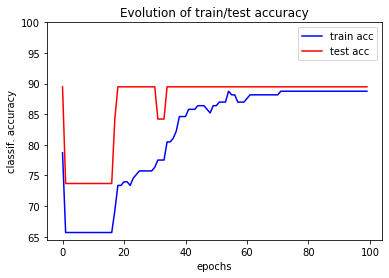

In [29]:
W = single_run(diags, feats, labels, filts, model, optim_parameters, test_size, 
               visualize_weight=True, 
               #gmin=.8, gmax=1.2)
               xmin=0., xmax=1., xstep=.001, ymin=0., ymax=1., ystep=.001)

In [ ]:
import pickle as pck
pck.dump(W, open("weights.pck", "wb"))

# Bibliography

[1] _PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams._
Mathieu Carrière, Frederic Chazal, Yuichi Ike, Théo Lacombe, Martin Royer, Yuhei Umeda.

[2] _Deep Sets._
Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan Salakhutdinov, Alexander Smola.
_Advances in Neural Information Processing Systems 30 (NIPS 2017)_

[3] _Deep Learning with Topological Signatures._
Christoph Hofer, Roland Kwitt, Marc Niethammer, Andreas Uhl
_Advances in Neural Information Processing Systems 30 (NIPS 2017)_